In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [43]:
monthly_data = pd.read_csv('returns.csv')

# Remove unwanted stock columns
columns_to_remove = ['ABBV', 'CAN', 'FB', 'GOOGL', 'LIN','META', 'TSLA']
monthly_data = monthly_data.drop(columns=columns_to_remove)

# Convert time column to datetime and set as index
monthly_data['Date'] = pd.to_datetime(monthly_data['Time'])
monthly_data = monthly_data.set_index('Date')

# Drop the now-unneeded Time column
monthly_data_numeric = monthly_data.drop(columns=['Time'])


/var/folders/w6/_spcqm2s663c654d8zzr6blh0000gn/T/ipykernel_87397/1644633714.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_data['Date'] = pd.to_datetime(monthly_data['Time'])


In [44]:
# Read and fix market cap data

marketcap_data = pd.read_csv('market_caps.csv')

# Get rid of both Grand Total column and Grand Total row
marketcap_data = marketcap_data.drop(columns=['Grand Total'])
marketcap_data = marketcap_data.drop(len(marketcap_data)-1)

# Change index to Date and put in proper format
marketcap_data['Date'] = pd.to_datetime(marketcap_data['Row Labels'])
marketcap_data = marketcap_data.set_index('Date')
marketcap_data = marketcap_data.drop(columns=['Row Labels'])


/var/folders/w6/_spcqm2s663c654d8zzr6blh0000gn/T/ipykernel_87397/4124939466.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  marketcap_data['Date'] = pd.to_datetime(marketcap_data['Row Labels'])


In [45]:
#Correlation Matrix Function
def make_correlation(start_idx, end_idx):
    df = monthly_data_numeric.iloc[start_idx:end_idx]
    
    X = df - df.mean()
    n = len(df)
    cov = (X.T @ X) / (n - 1)

    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    return pd.DataFrame(corr, index=df.columns, columns=df.columns)


In [46]:
#Gurobi Clustering with correlation matrix
from gurobipy import Model, GRB, quicksum

def gurobi_clustering(correlation_matrix, K):
    assets = correlation_matrix.columns.tolist()
    # Number of variables
    n = correlation_matrix.shape[0]
    # Create a new model
    m = Model("clustering")
    m.params.OutputFlag= 0
    # Create binary variables for each pair of variables
    x = m.addVars(n, n, vtype=GRB.BINARY, name="x")
    y = m.addVars(n, vtype=GRB.BINARY, name="y")
    # Objective: maximize the sum of correlations within clusters
    m.setObjective(quicksum(correlation_matrix.iloc[i, j] * x[i, j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)

    # Add constraints to ensure each variable is assigned to exactly one cluster
    for i in range(n):
        m.addConstr(quicksum(x[i, j] for j in range(n)) == 1, name=f"assign_{i}")

    #add constraint y_j = K
    m.addConstr(quicksum(y[j] for j in range(n)) == K, name=f"cluster_size")

    # x_ij <= y_j
    for i in range(n):
        for j in range(n):
            m.addConstr(x[i, j] <= y[j], name=f"link_{i}_{j}")

    # Optimize the model
    m.optimize()

    # Extract solution
    clusters = {}
    for j in range(n):
        if y[j].X > 0.5:  # j is a cluster representative
            primary = assets[j]
            clusters[primary] = [
                assets[i] for i in range(n) if x[i, j].X > 0.5
            ]
    return clusters

clusters = gurobi_clustering(make_correlation(0,120), 5)

In [47]:
def make_equal_weights(k, clusters):
    weights = {}
    for cluster in clusters.keys():
        weights[cluster] = 1/k
    return weights

def make_marketcap_weights(index, clusters):
    marketcap_weights = {}
    for cluster, stocks in clusters.items():
        total_cap = marketcap_data.iloc[index, :].sum()
        cluster_cap = 0
        for stock in stocks:
            column = marketcap_data.columns.get_loc(stock)
            cluster_cap += marketcap_data.iloc[index, column]
        marketcap_weights[cluster] = cluster_cap / total_cap
    return marketcap_weights


In [48]:
def compute_tracking_weights_gurobi(selected_assets, end_idx, window=120):
    """
    Compute variance-tracking weights for a subset of assets to match
    an equal-weighted benchmark across all assets.
    
    Parameters
    ----------
    selected_assets : list of str
        Subset of tickers to optimize weights for.
    end_idx : int
        Row index (exclusive) to end window.
    window : int
        Lookback window length.
    
    Returns
    -------
    dict
        Mapping {ticker: weight}.
    """
    import numpy as np
    import gurobipy as gp
    from gurobipy import GRB

    start_idx = end_idx - window

    # --- Full benchmark returns ---
    numeric_cols = monthly_data.select_dtypes(include=np.number).columns
    R_full = monthly_data.iloc[start_idx:end_idx][numeric_cols].astype(float).values
    T_full, K_full = R_full.shape

    # Equal-weight benchmark return vector
    w_bench_full = np.ones(K_full) / K_full
    r_bench_vec = R_full @ w_bench_full      # shape (T,)

    # --- Selected assets ---
    R = monthly_data.iloc[start_idx:end_idx][selected_assets].astype(float).values
    T, K = R.shape
    if T <= 1:
        raise ValueError(f"Not enough data points for window={window}")

    # ---------- Tracking-error QP ----------
    # Objective: min_w (1/2) w^T (2 R^T R) w  - (2 R^T r_bench)^T w
    Q = 2.0 * (R.T @ R)                       # Quadratic term
    c = -2.0 * (R.T @ r_bench_vec)            # Linear term

    # ---------- Solve with Gurobi ----------
    m = gp.Model("variance_tracking")
    m.Params.OutputFlag = 0

    w = m.addMVar(shape=K, lb=0.0, name="w")  # long-only; remove lb=0.0 for unconstrained
    m.setObjective(0.5 * w @ Q @ w + c @ w, GRB.MINIMIZE)

    m.addConstr(w.sum() == 1.0)

    m.optimize()

    if m.Status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        raise RuntimeError(f"Gurobi failed (status {m.Status})")

    return dict(zip(selected_assets, w.X))


In [49]:
# Calculate Returns
def calculate_return(weights, index):
    ret = 0
    for stock, weight in weights.items():
        column = monthly_data.columns.get_loc(stock)
        stock_ret = monthly_data.iloc[index, column]
        ret += stock_ret * weight
    return ret

def portfolio_growth(returns):
    balance = 1.0
    curve = [balance]
    for r in returns:
        balance *= (1 + r)
        curve.append(balance)
    return curve

def mse(returns1, returns2):
    n = len(returns1)
    error = 0
    for i in range(n):
        error += (returns1[i] - returns2[i])**2
    return error / n

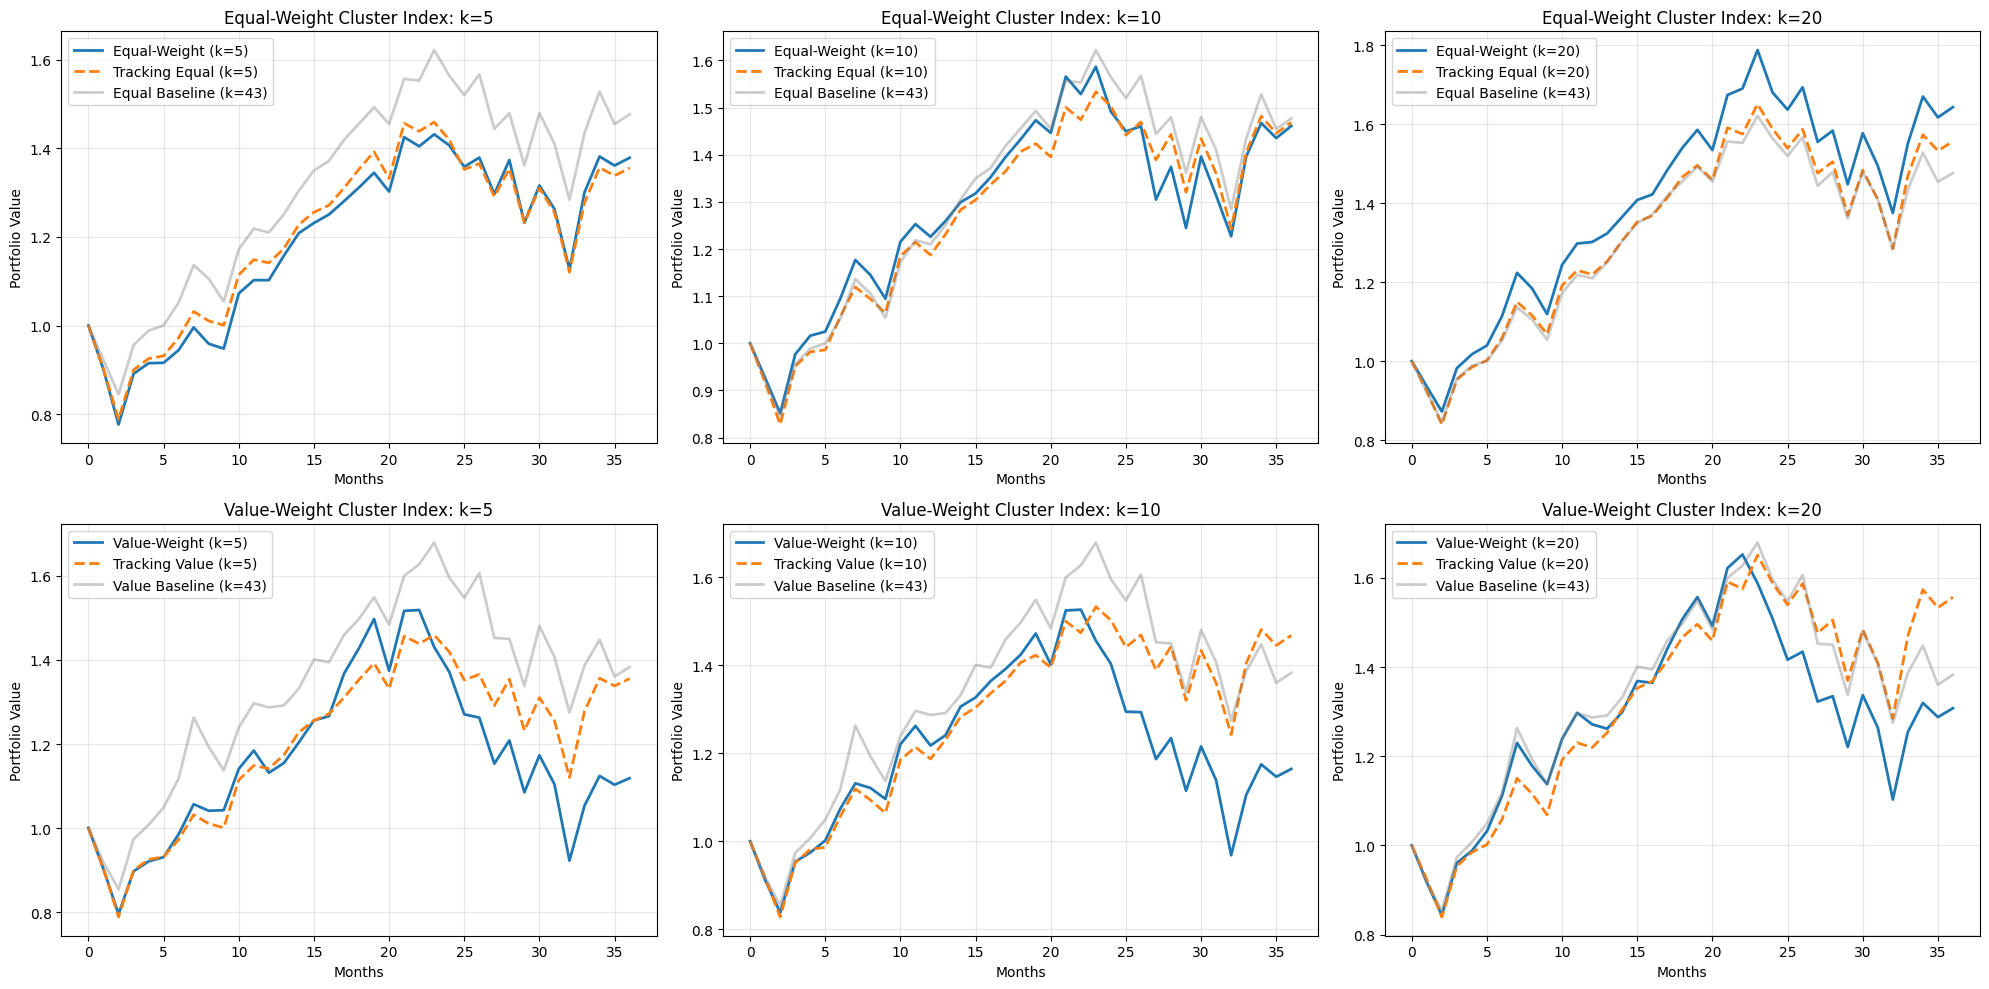


==================== MSE TABLE ====================
         Portfolio   k       MSE
0            Equal   5  0.000411
1            Value   5  0.001210
2   Tracking Equal   5  0.000314
3   Tracking Value   5  0.000849
4            Equal  10  0.000236
5            Value  10  0.000979
6   Tracking Equal  10  0.000156
7   Tracking Value  10  0.000688
8            Equal  20  0.000122
9            Value  20  0.000396
10  Tracking Equal  20  0.000069
11  Tracking Value  20  0.000410


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -------------------------
# PARAMETERS
# -------------------------
k_values = [5, 10, 20]
T = 120
N = monthly_data.shape[0]
start_return_idx = T + 1
n_periods = N - start_return_idx

# ---------------------------------------------------------
# STEP 1 — COMPUTE BASELINES (k = 43)
# ---------------------------------------------------------
baseline_equal_returns = []
baseline_value_returns = []

for i in range(start_return_idx, N):
    start_idx = i - (T + 1)
    end_idx = i - 1

    corr_mat = make_correlation(start_idx, end_idx)
    clusters_43 = gurobi_clustering(corr_mat, 43)

    eq_w = make_equal_weights(43, clusters_43)
    val_w = make_marketcap_weights(i - 1, clusters_43)

    baseline_equal_returns.append(calculate_return(eq_w, i))
    baseline_value_returns.append(calculate_return(val_w, i))

baseline_equal_curve = portfolio_growth(baseline_equal_returns)
baseline_value_curve = portfolio_growth(baseline_value_returns)

baseline_equal_returns = np.array(baseline_equal_returns)
baseline_value_returns = np.array(baseline_value_returns)

# ---------------------------------------------------------
# STEP 2 — COMPUTE CURVES FOR k = 5,10,20
# Includes separate variance-tracking portfolios
# ---------------------------------------------------------
results_equal = {}
results_value = {}
results_tracking_equal = {}
results_tracking_value = {}
all_results = []

for k in k_values:
    eq_rets = []
    val_rets = []
    track_eq_rets = []
    track_val_rets = []

    for i in range(start_return_idx, N):
        start_idx = i - (T + 1)
        end_idx = i - 1

        corr_mat = make_correlation(start_idx, end_idx)
        clusters = gurobi_clustering(corr_mat, k)
        selected_assets = list(clusters.keys())

        # ---- Equal-weight index ----
        eq_w = make_equal_weights(k, clusters)
        eq_rets.append(calculate_return(eq_w, i))

        # ---- Value-weight index ----
        val_w = make_marketcap_weights(i - 1, clusters)
        val_rets.append(calculate_return(val_w, i))

        # ---- Variance-tracking portfolios ----
        track_eq_w = compute_tracking_weights_gurobi(selected_assets, i, window=T)
        track_eq_rets.append(calculate_return(track_eq_w, i))

        track_val_w = compute_tracking_weights_gurobi(selected_assets, i, window=T)
        track_val_rets.append(calculate_return(track_val_w, i))

    # ---- Compute MSEs vs appropriate baselines ----
    equal_port_error = mse(eq_rets, baseline_equal_returns)
    value_port_error = mse(val_rets, baseline_value_returns)
    track_eq_error = mse(track_eq_rets, baseline_equal_returns)
    track_val_error = mse(track_val_rets, baseline_value_returns)

    # ---- Store results in DataFrame ----
    results = pd.DataFrame({
        "Portfolio": ["Equal", "Value", "Tracking Equal", "Tracking Value"],
        "k": [k, k, k, k],
        "MSE": [equal_port_error, value_port_error, track_eq_error, track_val_error]
    })
    all_results.append(results)

    # ---- Store growth curves ----
    results_equal[k] = portfolio_growth(eq_rets)
    results_value[k] = portfolio_growth(val_rets)
    results_tracking_equal[k] = portfolio_growth(track_eq_rets)
    results_tracking_value[k] = portfolio_growth(track_val_rets)

# ---------------------------------------------------------
# STEP 3 — PLOTTING WITH VARIANCE TRACKING ADDED
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.35)

# ----------- TOP ROW: EQUAL WEIGHT ----------
for idx, k in enumerate(k_values):
    ax = axes[0, idx]

    ax.plot(results_equal[k], label=f"Equal-Weight (k={k})", linewidth=2)
    ax.plot(results_tracking_equal[k], label=f"Tracking Equal (k={k})", linewidth=2, linestyle="--")
    ax.plot(baseline_equal_curve, label="Equal Baseline (k=43)", color="gray", alpha=0.4, linewidth=2)

    ax.set_title(f"Equal-Weight Cluster Index: k={k}", fontsize=12)
    ax.set_xlabel("Months")
    ax.set_ylabel("Portfolio Value")
    ax.grid(True, alpha=0.3)
    ax.legend()

# ----------- BOTTOM ROW: VALUE WEIGHT ----------
for idx, k in enumerate(k_values):
    ax = axes[1, idx]

    ax.plot(results_value[k], label=f"Value-Weight (k={k})", linewidth=2)
    ax.plot(results_tracking_value[k], label=f"Tracking Value (k={k})", linewidth=2, linestyle="--")
    ax.plot(baseline_value_curve, label="Value Baseline (k=43)", color="gray", alpha=0.4, linewidth=2)

    ax.set_title(f"Value-Weight Cluster Index: k={k}", fontsize=12)
    ax.set_xlabel("Months")
    ax.set_ylabel("Portfolio Value")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# STEP 4 — OPTIONAL: Combined MSE table
# ---------------------------------------------------------
df_all_results = pd.concat(all_results, ignore_index=True)
print("\n==================== MSE TABLE ====================")
print(df_all_results.round(6))


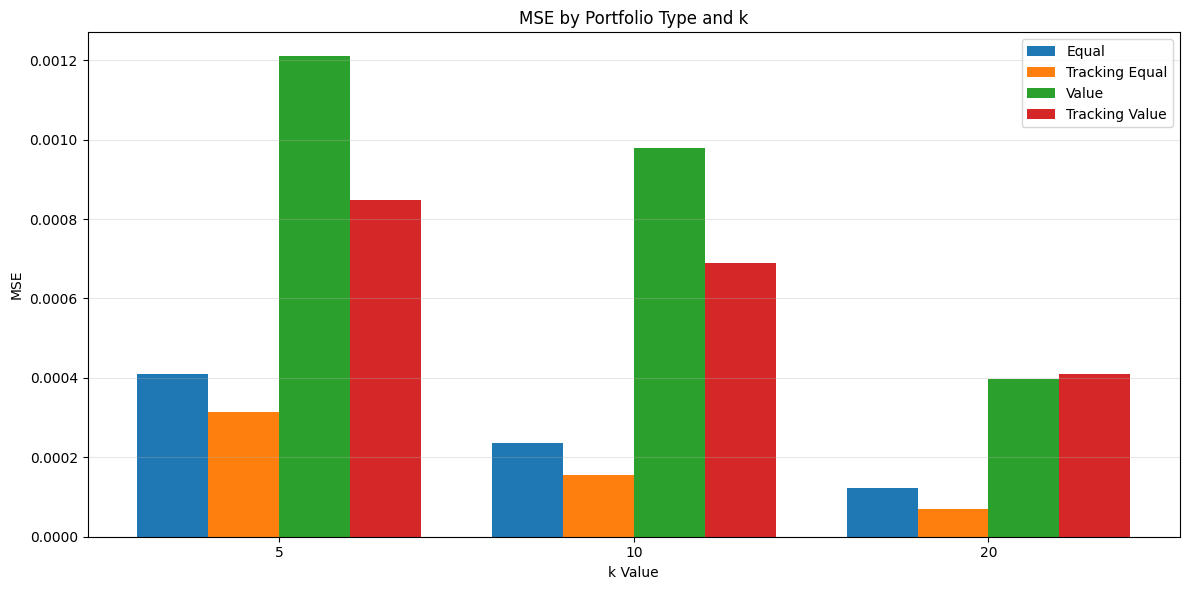

In [51]:
# ------------------------------------------------------------
# FINAL: Plot all results in one grouped bar chart (including Tracking Value)
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Concatenate all results
df = pd.concat(all_results, ignore_index=True)

# ensure consistent bar ordering
portfolio_order = ["Equal", "Tracking Equal", "Value", "Tracking Value"]
df["Portfolio"] = pd.Categorical(df["Portfolio"], categories=portfolio_order, ordered=True)

unique_k = sorted(df["k"].unique())
x = np.arange(len(unique_k))
bar_width = 0.2  # smaller width to fit 4 bars

plt.figure(figsize=(12, 6))

for idx, portfolio in enumerate(portfolio_order):
    subset = df[df["Portfolio"] == portfolio].sort_values("k")
    plt.bar(
        x + idx * bar_width,
        subset["MSE"],
        width=bar_width,
        label=portfolio
    )

plt.xticks(x + 1.5 * bar_width, unique_k)  # center labels under grouped bars
plt.xlabel("k Value")
plt.ylabel("MSE")
plt.title("MSE by Portfolio Type and k")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
from gurobipy import Model, GRB, quicksum

def gurobi_clustering_with_turnover(correlation_matrix, K, previous_cluster_vector=None, max_turnover=None):
    """
    correlation_matrix: pd.DataFrame of correlations
    K: number of clusters
    previous_cluster_vector: list of 0/1 indicating previous cluster representatives
    max_turnover: maximum allowed number of representatives that may change
    """
    assets = correlation_matrix.columns.tolist()
    n = correlation_matrix.shape[0]

    # Make a clean correlation copy with zeroed diagonal
    C = correlation_matrix.copy().astype(float)

    # Create model
    m = Model("correlation_clustering")
    m.Params.OutputFlag = 0

    # Decision variables
    x = m.addVars(n, n, vtype=GRB.BINARY, name="x")  # x[i,j] asset i assigned to rep j
    y = m.addVars(n, vtype=GRB.BINARY, name="y")     # y[j] = representative j

    # Objective: maximize total within-cluster correlation
    m.setObjective(
        quicksum(C.iat[i, j] * x[i, j] for i in range(n) for j in range(n)),
        GRB.MAXIMIZE
    )

    # 1. Each asset assigned to exactly ONE cluster representative
    for i in range(n):
        m.addConstr(quicksum(x[i, j] for j in range(n)) == 1, name=f"assign_{i}")

    # 2. Exactly K cluster representatives
    m.addConstr(quicksum(y[j] for j in range(n)) == K, name="num_clusters")

    # 3. Linking constraint: assets assigned only to active representatives
    for i in range(n):
        for j in range(n):
            m.addConstr(x[i, j] <= y[j], name=f"link_{i}_{j}")

    # 4. Representative must represent itself
    for j in range(n):
        m.addConstr(x[j, j] == y[j], name=f"self_assign_{j}")

    # 5. Turnover constraint using L1 Hamming distance
    if previous_cluster_vector is not None and max_turnover is not None:
        turnover_vars = []
        for j in range(n):
            t = m.addVar(vtype=GRB.BINARY, name=f"turnover_{j}")
            prev = previous_cluster_vector[j]
            # t_j >= |y_j - prev_j|
            m.addConstr(t >= y[j] - prev)
            m.addConstr(t >= prev - y[j])
            turnover_vars.append(t)

        m.addConstr(quicksum(turnover_vars) <= 2 * max_turnover, name="turnover_limit")

    # Solve model
    m.optimize()

    # Extract solution
    clusters = {}
    new_cluster_vector = []

    for j in range(n):
        if y[j].X > 0.5:
            new_cluster_vector.append(1)
            rep_asset = assets[j]
            members = [assets[i] for i in range(n) if x[i, j].X > 0.5]
            clusters[rep_asset] = members
        else:
            new_cluster_vector.append(0)

    return clusters, new_cluster_vector


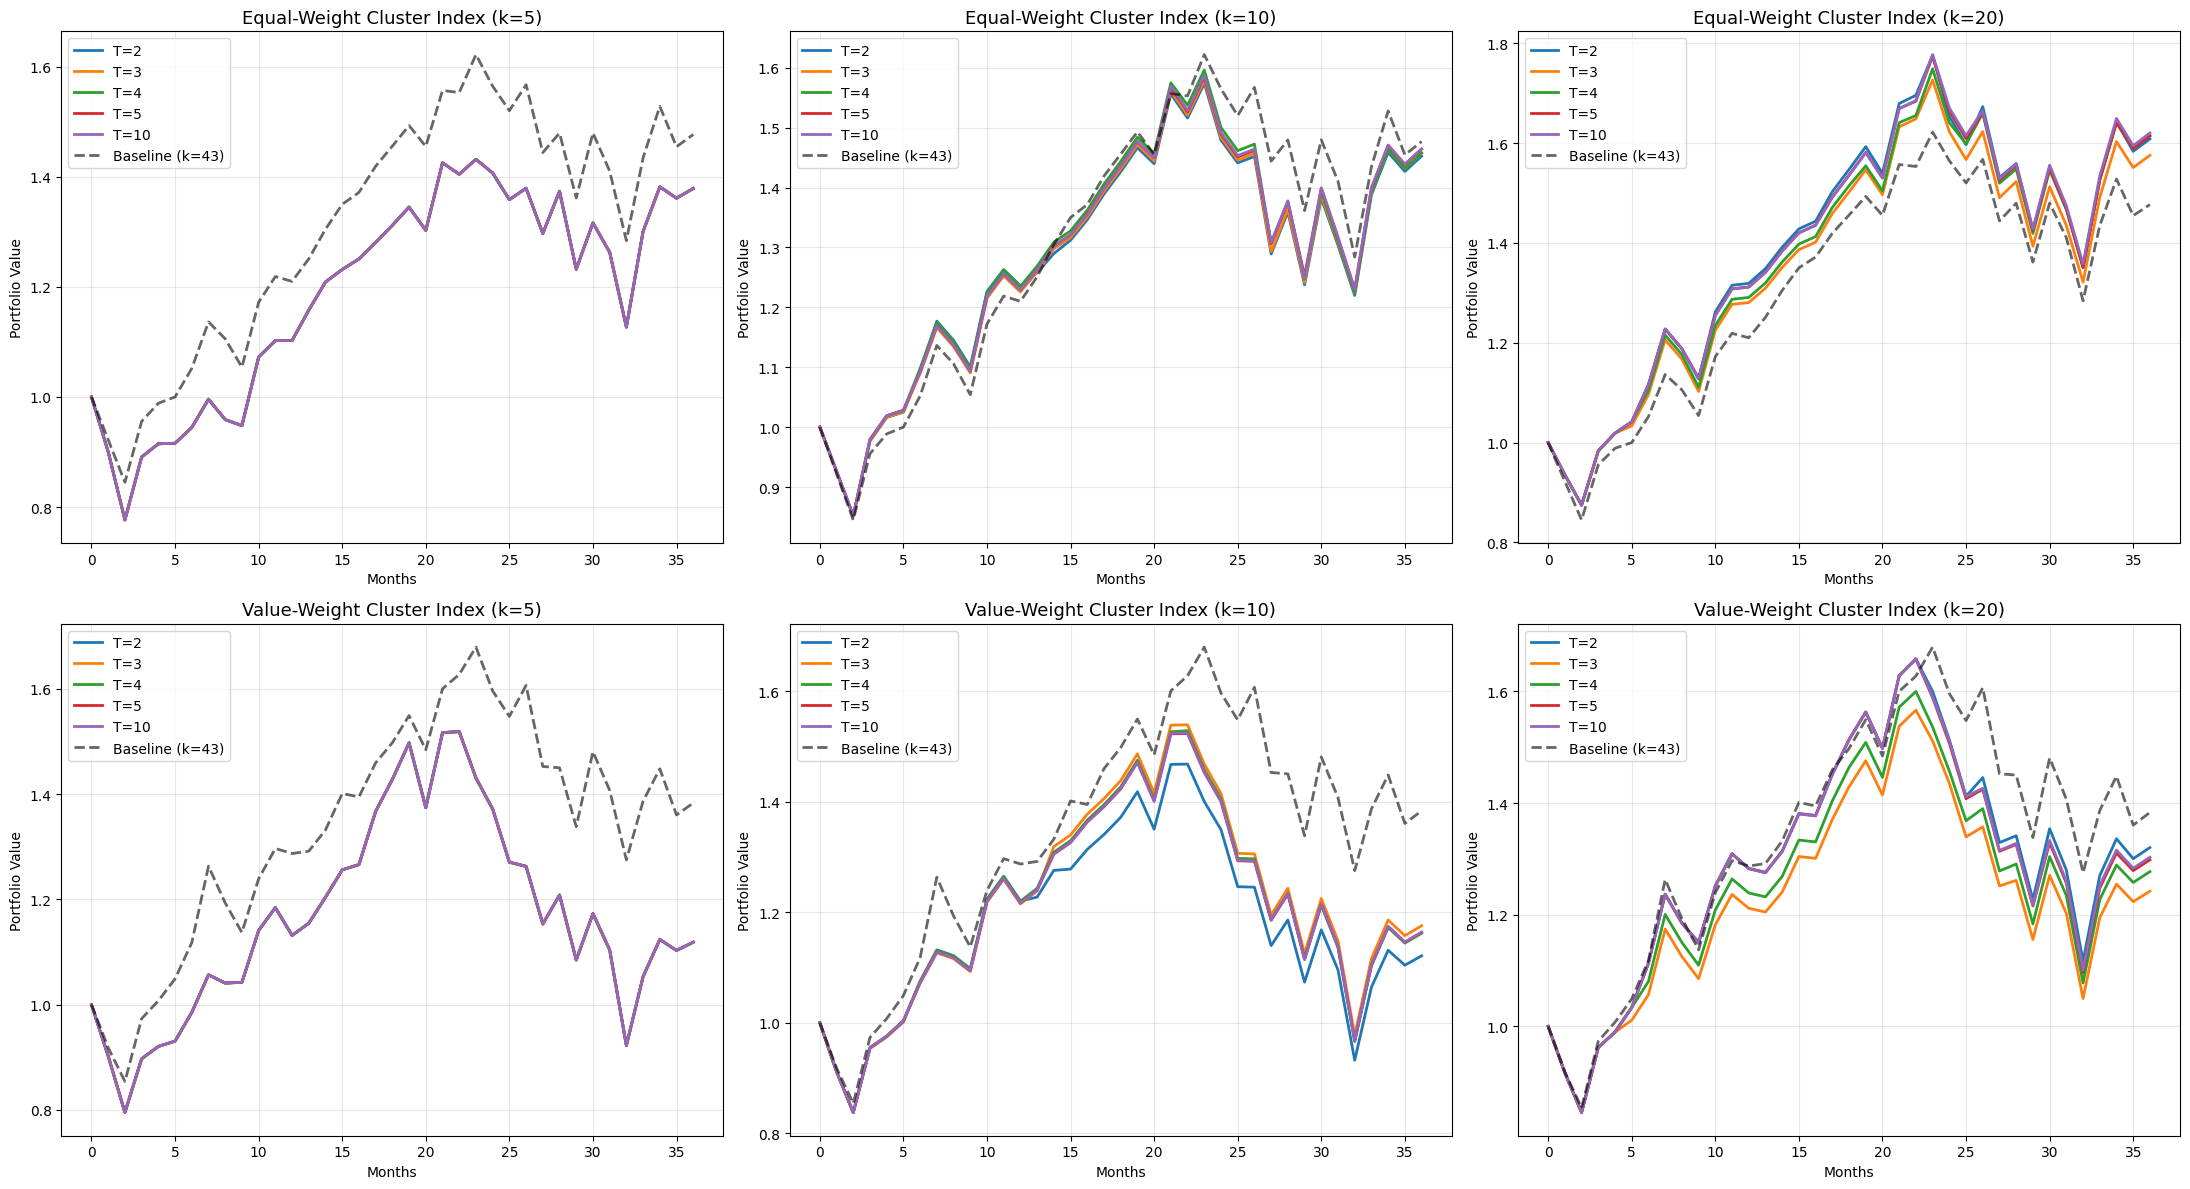



==================== MSE (Equal-Weight Cluster Index) ====================
          2         3         4         5         10
5   0.000411  0.000411  0.000411  0.000411  0.000411
10  0.000250  0.000239  0.000243  0.000229  0.000241
20  0.000135  0.000101  0.000113  0.000115  0.000113


==================== MSE (Value-Weight Cluster Index) ====================
          2         3         4         5         10
5   0.001210  0.001210  0.001210  0.001210  0.001210
10  0.000993  0.001004  0.000989  0.000988  0.000989
20  0.000365  0.000393  0.000388  0.000411  0.000406


In [68]:
# ----------------------------------------------------------
# RUNNING CLUSTER-INDEX BACKTEST WITH MULTIPLE TURNOVER LIMITS
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

k_values = [5, 10, 20]
T = 120
N = monthly_data.shape[0]
start_return_idx = T + 1
turnover_values = [2,3,4,5,10]

# ----------------------------------------------------------
# STEP 2 — RUN EXPERIMENT ACROSS k VALUES AND TURNOVER LIMITS
# ----------------------------------------------------------

results_equal = {k: {} for k in k_values}
results_value = {k: {} for k in k_values}

# Containers for MSE
mse_equal = {k: {} for k in k_values}
mse_value = {k: {} for k in k_values}

for k in k_values:
    for max_turnover in turnover_values:

        eq_rets, val_rets = [], []
        prev_cluster_vector_equal = None
        prev_cluster_vector_value = None

        for i in range(start_return_idx, N):
            start_idx = i - (T + 1)
            end_idx = i - 1

            corr_mat = make_correlation(start_idx, end_idx)

            # ----- Equal-Weight Cluster Index -----
            clusters_eq, new_cluster_vector_eq = gurobi_clustering_with_turnover(
                corr_mat, k,
                previous_cluster_vector=prev_cluster_vector_equal,
                max_turnover=max_turnover
            )
            prev_cluster_vector_equal = new_cluster_vector_eq

            eq_w = make_equal_weights(k, clusters_eq)
            eq_rets.append(calculate_return(eq_w, i))

            # ----- Value-Weight Cluster Index -----
            clusters_val, new_cluster_vector_val = gurobi_clustering_with_turnover(
                corr_mat, k,
                previous_cluster_vector=prev_cluster_vector_value,
                max_turnover=max_turnover
            )
            prev_cluster_vector_value = new_cluster_vector_val

            val_w = make_marketcap_weights(i - 1, clusters_val)
            val_rets.append(calculate_return(val_w, i))

        # Convert to arrays
        eq_rets = np.array(eq_rets)
        val_rets = np.array(val_rets)

        # Store curves
        results_equal[k][max_turnover] = portfolio_growth(eq_rets)
        results_value[k][max_turnover] = portfolio_growth(val_rets)

        # ---- MSE COMPUTATION ----
        mse_equal[k][max_turnover] = np.mean((eq_rets - baseline_equal_returns)**2)
        mse_value[k][max_turnover] = np.mean((val_rets - baseline_value_returns)**2)


# ----------------------------------------------------------
# STEP 3 — PLOTS
# ----------------------------------------------------------

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
plt.subplots_adjust(wspace=0.25, hspace=0.35)

# -------- Equal-weight (top row)
for idx, k in enumerate(k_values):
    ax = axes[0, idx]
    for max_turnover in turnover_values:
        ax.plot(results_equal[k][max_turnover], label=f"T={max_turnover}", linewidth=2)
    ax.plot(baseline_equal_curve, label="Baseline (k=43)",
            color="black", linestyle="--", alpha=0.6, linewidth=2)
    ax.set_title(f"Equal-Weight Cluster Index (k={k})", fontsize=13)
    ax.set_xlabel("Months")
    ax.set_ylabel("Portfolio Value")
    ax.grid(True, alpha=0.3)
    ax.legend()

# -------- Value-weight (bottom row)
for idx, k in enumerate(k_values):
    ax = axes[1, idx]
    for max_turnover in turnover_values:
        ax.plot(results_value[k][max_turnover], label=f"T={max_turnover}", linewidth=2)
    ax.plot(baseline_value_curve, label="Baseline (k=43)",
            color="black", linestyle="--", alpha=0.6, linewidth=2)
    ax.set_title(f"Value-Weight Cluster Index (k={k})", fontsize=13)
    ax.set_xlabel("Months")
    ax.set_ylabel("Portfolio Value")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


# ----------------------------------------------------------
# STEP 4 — PRINT MSE TABLES
# ----------------------------------------------------------

df_equal = pd.DataFrame(mse_equal).T
df_value = pd.DataFrame(mse_value).T

print("\n\n==================== MSE (Equal-Weight Cluster Index) ====================")
print(df_equal.round(6))

print("\n\n==================== MSE (Value-Weight Cluster Index) ====================")
print(df_value.round(6))


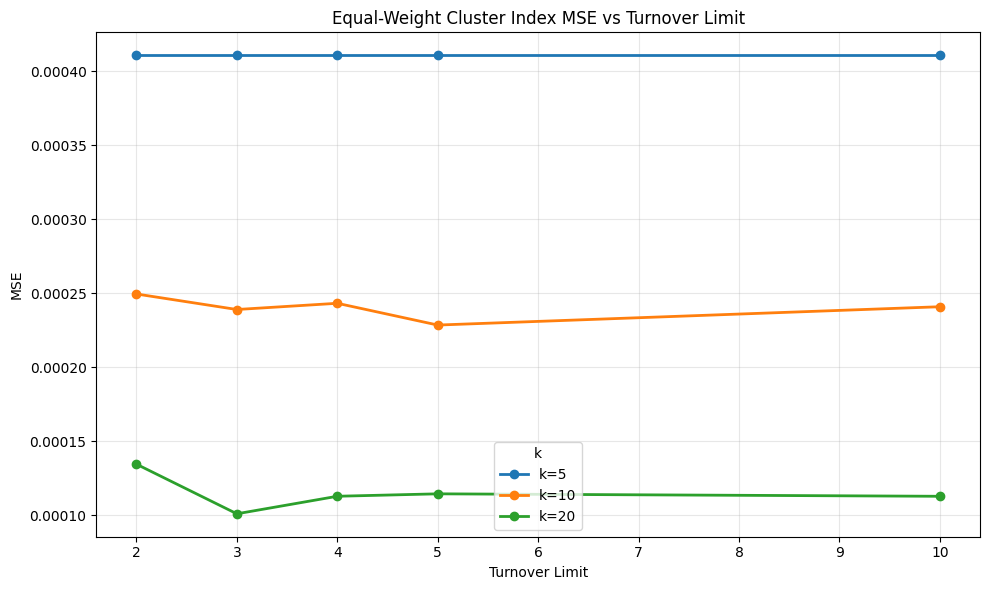

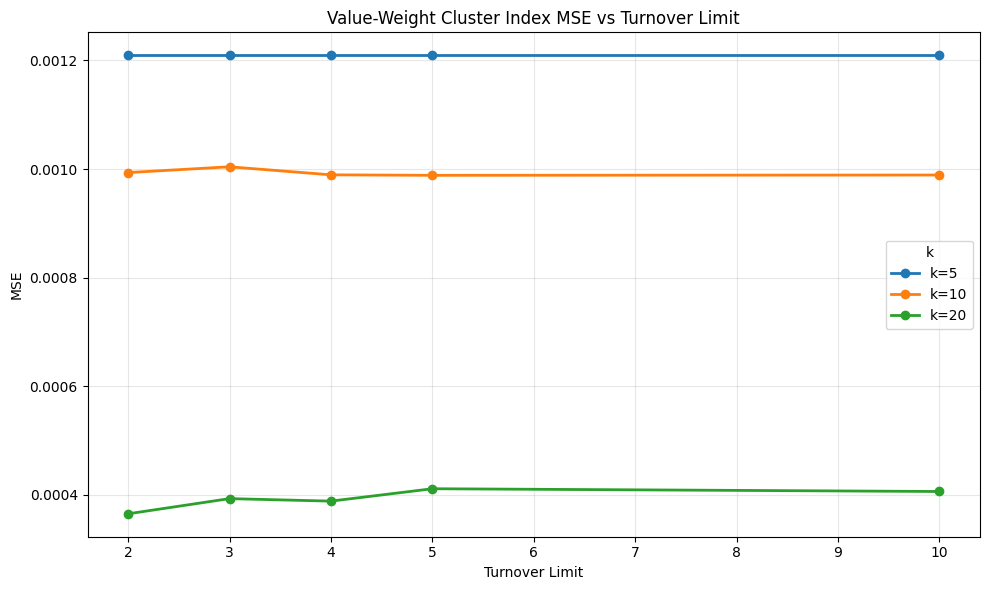

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Extract turnover values (assumes all k have same turnover keys)
turnover_values = sorted(next(iter(mse_equal.values())).keys())
k_values = sorted(mse_equal.keys())

# -------------------------
# Equal-weight MSE line plot
# -------------------------
plt.figure(figsize=(10, 6))

for k in k_values:
    mse_vals = [mse_equal[k][t] for t in turnover_values]
    plt.plot(turnover_values, mse_vals, marker='o', linewidth=2, label=f"k={k}")

plt.xlabel("Turnover Limit")
plt.ylabel("MSE")
plt.title("Equal-Weight Cluster Index MSE vs Turnover Limit")
plt.grid(True, alpha=0.3)
plt.legend(title="k")
plt.tight_layout()
plt.show()

# -------------------------
# Value-weight MSE line plot
# -------------------------
plt.figure(figsize=(10, 6))

for k in k_values:
    mse_vals = [mse_value[k][t] for t in turnover_values]
    plt.plot(turnover_values, mse_vals, marker='o', linewidth=2, label=f"k={k}")

plt.xlabel("Turnover Limit")
plt.ylabel("MSE")
plt.title("Value-Weight Cluster Index MSE vs Turnover Limit")
plt.grid(True, alpha=0.3)
plt.legend(title="k")
plt.tight_layout()
plt.show()
